In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
from IPython.display import display
import logging
logging.basicConfig(level=logging.DEBUG)

%matplotlib notebook

DEBUG:matplotlib.pyplot:Loaded backend nbAgg version unknown.


In [35]:
# Function Def

def calculate_normal_modes(M, K):
    """
    Calculate the natural frequencies and normal modes of a mass-spring system.

    Parameters:
        M (ndarray): Mass matrix (n x n), typically diagonal with masses on the diagonal.
        K (ndarray): Stiffness matrix (n x n), describing the spring connections.

    Returns:
        frequencies (ndarray): Natural frequencies of the system.
        modes (ndarray): Normalized eigenvectors (mode shapes) of the system.
    """
    # Ensure matrices are numpy arrays
    M = np.array(M)
    K = np.array(K)

    # Solve the generalized eigenvalue problem: (K - \omega^2 M) \mathbf{A} = 0
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(M) @ K)

    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Natural frequencies are the square root of the eigenvalues
    frequencies = np.sqrt(np.maximum(eigenvalues, 0))  # Ensure non-negative values

    return frequencies, eigenvectors

def assemble_stiffness_2d(nodes, springs, k_values):
    """
    Assemble the global stiffness matrix for a 2D mass-spring network.
    
    Parameters:
        nodes (list of tuples): Coordinates of the nodes [(x1, y1), (x2, y2), ...].
        springs (list of tuples): Pairs of connected nodes [(i, j), (j, k), ...].
        k_values (list): Spring constants for each spring.
    
    Returns:
        K (ndarray): Global stiffness matrix (2n x 2n).
    """
    n = len(nodes)
    K = np.zeros((2 * n, 2 * n))  # Global stiffness matrix
    
    for (i, j), k in zip(springs, k_values):
        # Node coordinates
        x_i, y_i = nodes[i]
        x_j, y_j = nodes[j]
        
        # Spring properties
        dx, dy = x_j - x_i, y_j - y_i
        L = np.sqrt(dx**2 + dy**2)  # Length of the spring
        u_x, u_y = dx / L, dy / L  # Unit vector
        
        # Local stiffness matrix
        k_spring = k * np.array([
            [u_x**2, u_x*u_y, -u_x**2, -u_x*u_y],
            [u_x*u_y, u_y**2, -u_x*u_y, -u_y**2],
            [-u_x**2, -u_x*u_y, u_x**2, u_x*u_y],
            [-u_x*u_y, -u_y**2, u_x*u_y, u_y**2]
        ])
        
        # Map to global matrix
        dof = [2*i, 2*i+1, 2*j, 2*j+1]
        for a in range(4):
            for b in range(4):
                K[dof[a], dof[b]] += k_spring[a, b]
    
    return K


def visualize_modes_2d(nodes, springs, mode, frequency, num_frames=100):
    """
    Visualize a mode shape of a 2D mass-spring network.
    
    Parameters:
        nodes (ndarray): Node positions as [(x1, y1), (x2, y2), ...].
        springs (list of tuples): List of springs as [(i, j), ...].
        mode (ndarray): Mode shape (2n,).
        frequency (float): Natural frequency (rad/s).
        num_frames (int): Number of frames in the animation.
    
    Returns:
        tuple: (figure, animation) - Keep these references to prevent garbage collection
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
    # Extract node positions
    node_positions = np.array(nodes)
    x, y = node_positions[:, 0], node_positions[:, 1]
    
    # Initialize plot elements
    lines = [ax.plot([], [], 'k-', lw=2)[0] for _ in springs]
    scatter = ax.scatter([], [], c='red', s=50)
    print(f"Initial node positions:\n{node_positions}")
    print(f"Mode shape:\n{mode}")
    
    frame_count = 0
    last_time = time.time()
    
    # Initialize animation
    def init():
        print("Init function called")
        scatter.set_offsets(node_positions)
        for line, (i, j) in zip(lines, springs):
            line.set_data(
                [node_positions[i, 0], node_positions[j, 0]],
                [node_positions[i, 1], node_positions[j, 1]]
            )
        return lines + [scatter, title]
    
    # Update function
#     def update(frame):
#         t = (frame / num_frames) * (2 * np.pi / frequency)
#         displacement = np.sin(t) * mode.reshape(-1, 2)  # Ensure mode is reshaped
#         displaced_positions = node_positions + displacement  # Apply displacement
#         scatter.set_offsets(displaced_positions)  # Update scatter positions
#         for line, (i, j) in zip(lines, springs):
#             line.set_data(
#                 [displaced_positions[i, 0], displaced_positions[j, 0]],
#                 [displaced_positions[i, 1], displaced_positions[j, 1]]
#             )
#         return lines + [scatter]
    def update(frame):
        nonlocal frame_count, last_time
        
        # Debug timing
        current_time = time.time()
        elapsed = current_time - last_time
        frame_count += 1
        logging.debug(f"Frame {frame_count}, Time since last frame: {elapsed:.3f}s")
        last_time = current_time
        
        t = (frame / num_frames) * (2 * np.pi / frequency)
        displacement = np.sin(frequency * t) * mode.reshape(-1, 2)
        displaced_positions = node_positions + displacement
        
        print(f"Frame {frame}: t={t:.3f}, max displacement={np.max(np.abs(displacement)):.3f}")
        
        scatter.set_offsets(displaced_positions)
        return [scatter]
    
    # Create animation and store reference
    # Create animation with appropriate interval
    interval = np.real(1000 / (frequency * num_frames))  # Convert to milliseconds
    print(interval)
#     ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, 
#                        interval=interval, blit=True, repeat=True)

    ani = FuncAnimation(fig, update,frames=num_frames, interval=interval, 
                       blit=True, repeat=True)
    
    # Store animation in figure to prevent garbage collection
    fig.animation = ani  # This keeps the animation alive
    globals()['current_animation'] = ani  # Keep global reference

    plt.show(block = True)
    
    # Return both figure and animation to maintain references
    return fig, ani

###
def visualize_complex_modes_2d(nodes, springs, mode, frequency, num_frames=100):
    """
    Visualize a complex mode shape of a 2D mass-spring network.
    
    Parameters:
        nodes (ndarray): Node positions as [(x1, y1), (x2, y2), ...].
        springs (list of tuples): List of springs as [(i, j), ...].
        mode (ndarray): Complex mode shape (2n,).
        frequency (complex): Complex natural frequency (rad/s).
        num_frames (int): Number of frames in the animation.
    """
    print("Starting visualization setup...")
    plt.close('all')
    
    fig, ax = plt.subplots()
    print("Figure created")
    
    ax.set_aspect('equal')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
    # Convert inputs to numpy arrays if they aren't already
    node_positions = np.array(nodes)
    mode = np.array(mode, dtype=complex)
    frequency = complex(frequency)
    
    print(f"Initial node positions:\n{node_positions}")
    print(f"Complex mode shape:\n{mode}")
    print(f"Complex frequency: {frequency}")
    
    # Split frequency into real (damping) and imaginary (oscillation) parts
    damping = frequency.real
    omega = frequency.imag
    
    # Initialize plot elements
    lines = [ax.plot([], [], 'k-', lw=2)[0] for _ in springs]
    scatter = ax.scatter(node_positions[:, 0], node_positions[:, 1], c='red', s=50)
    
    # Title to show time
    title = ax.set_title(f"Time: 0.0 s")
    
    frame_count = [0]
    
    def init():
        print("Init function called")
        scatter.set_offsets(node_positions)
        for line, (i, j) in zip(lines, springs):
            line.set_data(
                [node_positions[i, 0], node_positions[j, 0]],
                [node_positions[i, 1], node_positions[j, 1]]
            )
        return lines + [scatter, title]
    
    def update(frame):
        frame_count[0] += 1
        
        # Calculate time for this frame
        t = (frame / num_frames) * (2 * np.pi / abs(omega))
        
        # Calculate complex displacement including damping
        # exp(frequency * t) = exp(damping * t) * exp(i * omega * t)
        time_factor = np.exp(damping * t) * np.exp(1j * omega * t)
        
        # Real part of complex displacement
        mode_2d = mode.reshape(-1, 2)
        displacement = np.real(time_factor * mode_2d)
        
        # Apply displacement to all nodes
        displaced_positions = node_positions + displacement
        
        # Update scatter plot
        scatter.set_offsets(displaced_positions)
        
        # Update springs
        for line, (i, j) in zip(lines, springs):
            line.set_data(
                [displaced_positions[i, 0], displaced_positions[j, 0]],
                [displaced_positions[i, 1], displaced_positions[j, 1]]
            )
            
        # Update title with current time
        title.set_text(f"Time: {t:.2f} s")
        
        # Print debug info occasionally
        if frame_count[0] % 10 == 0:
            print(f"Frame {frame_count[0]}, Time: {t:.2f}, Max displacement: {np.max(np.abs(displacement)):.3f}")
            
        return lines + [scatter, title]
    
    print("Creating animation...")
    
    # Create animation
    ani = FuncAnimation(
        fig, 
        update,
        init_func=init,
        frames=np.linspace(0, num_frames-1, num_frames),
        interval=50,
        blit=False,
        repeat=True
    )
    
    # Store reference to prevent garbage collection
    fig.animation = ani
    
    print("Animation object created")
    print(f"Animation details: {ani}")
    
    # Display the figure
    display(fig)
    
    return fig, ani
###

In [56]:
m = 1
n = 2*7 # 7 nodes, each with an x and y coordinate
l = 1
k = 1

M = np.diag(m*np.ones(n))
nodes = [(0,0), (0,l), (l*np.cos(np.pi/6), l*np.sin(np.pi/6)), (l*np.cos(np.pi/6), -l*np.sin(np.pi/6)),
        (0,-l), (-l*np.cos(np.pi/6), -l*np.sin(np.pi/6)), (-l*np.cos(np.pi/6), l*np.sin(np.pi/6))]

springs = [(0,1),(0,2),(0,3),(0,4),(0,5),(0,6),(1,2),(2,3),(3,4),(4,5),(5,6),(6,1)]
k_values = k*np.ones(n)

K = assemble_stiffness_2d(nodes, springs, k_values)
freqs, modes = calculate_normal_modes(M, K)
mode = [0,.1,0,0,0,0,0,0,0,0,0,0,0,0]

<IPython.core.display.Javascript object>


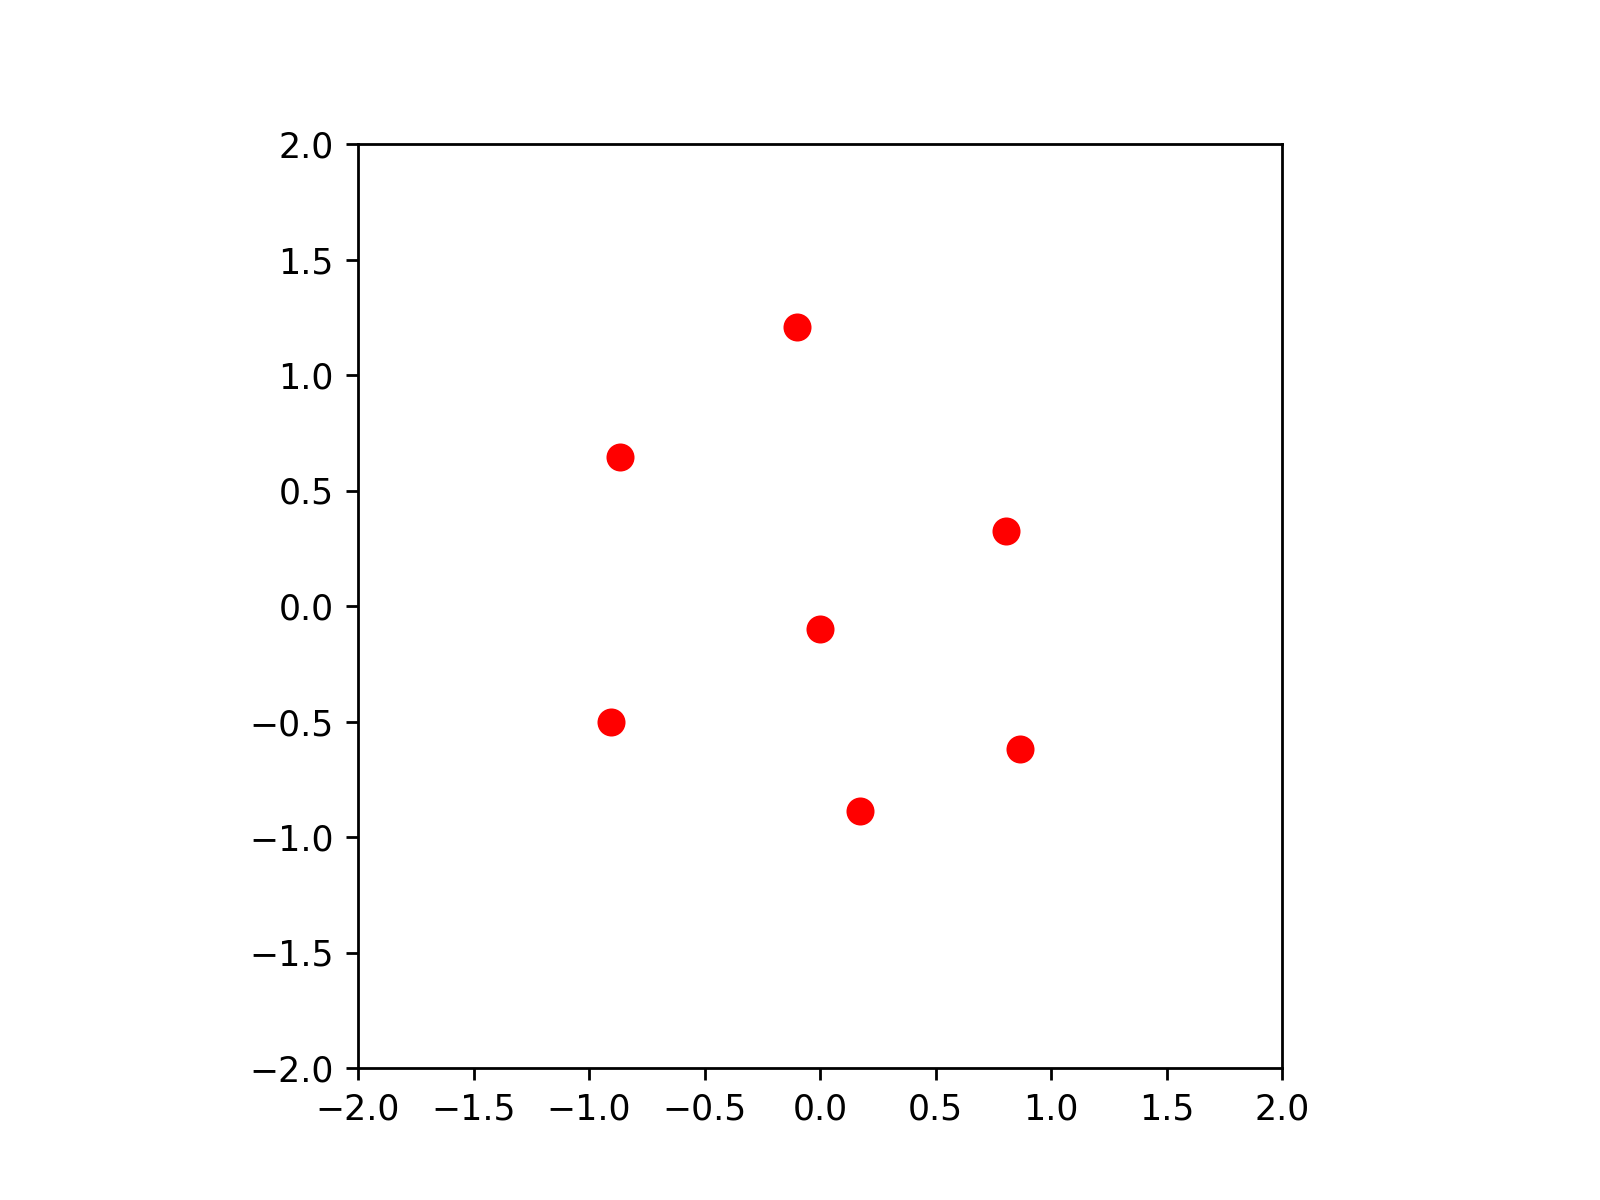

Initial node positions:
[[ 0.         0.       ]
 [ 0.         1.       ]
 [ 0.8660254  0.5      ]
 [ 0.8660254 -0.5      ]
 [ 0.        -1.       ]
 [-0.8660254 -0.5      ]
 [-0.8660254  0.5      ]]
Mode shape:
[ 0.00000000e+00+0.j          2.34148322e-01+0.08787713j
  2.34148322e-01-0.08787713j -4.85376761e-01+0.j
  1.47195379e-01+0.j          4.08248290e-01+0.j
  0.00000000e+00+0.j          2.75071579e-01+0.j
 -4.08248290e-01+0.j         -2.67951539e-01+0.j
  9.38362635e-02+0.j          6.29006414e-16+0.j
  0.00000000e+00+0.j         -3.38814851e-01+0.j        ]
5.0


In [57]:
fig, ani = visualize_modes_2d(nodes, springs, modes[3], 2)


<IPython.core.display.Javascript object>


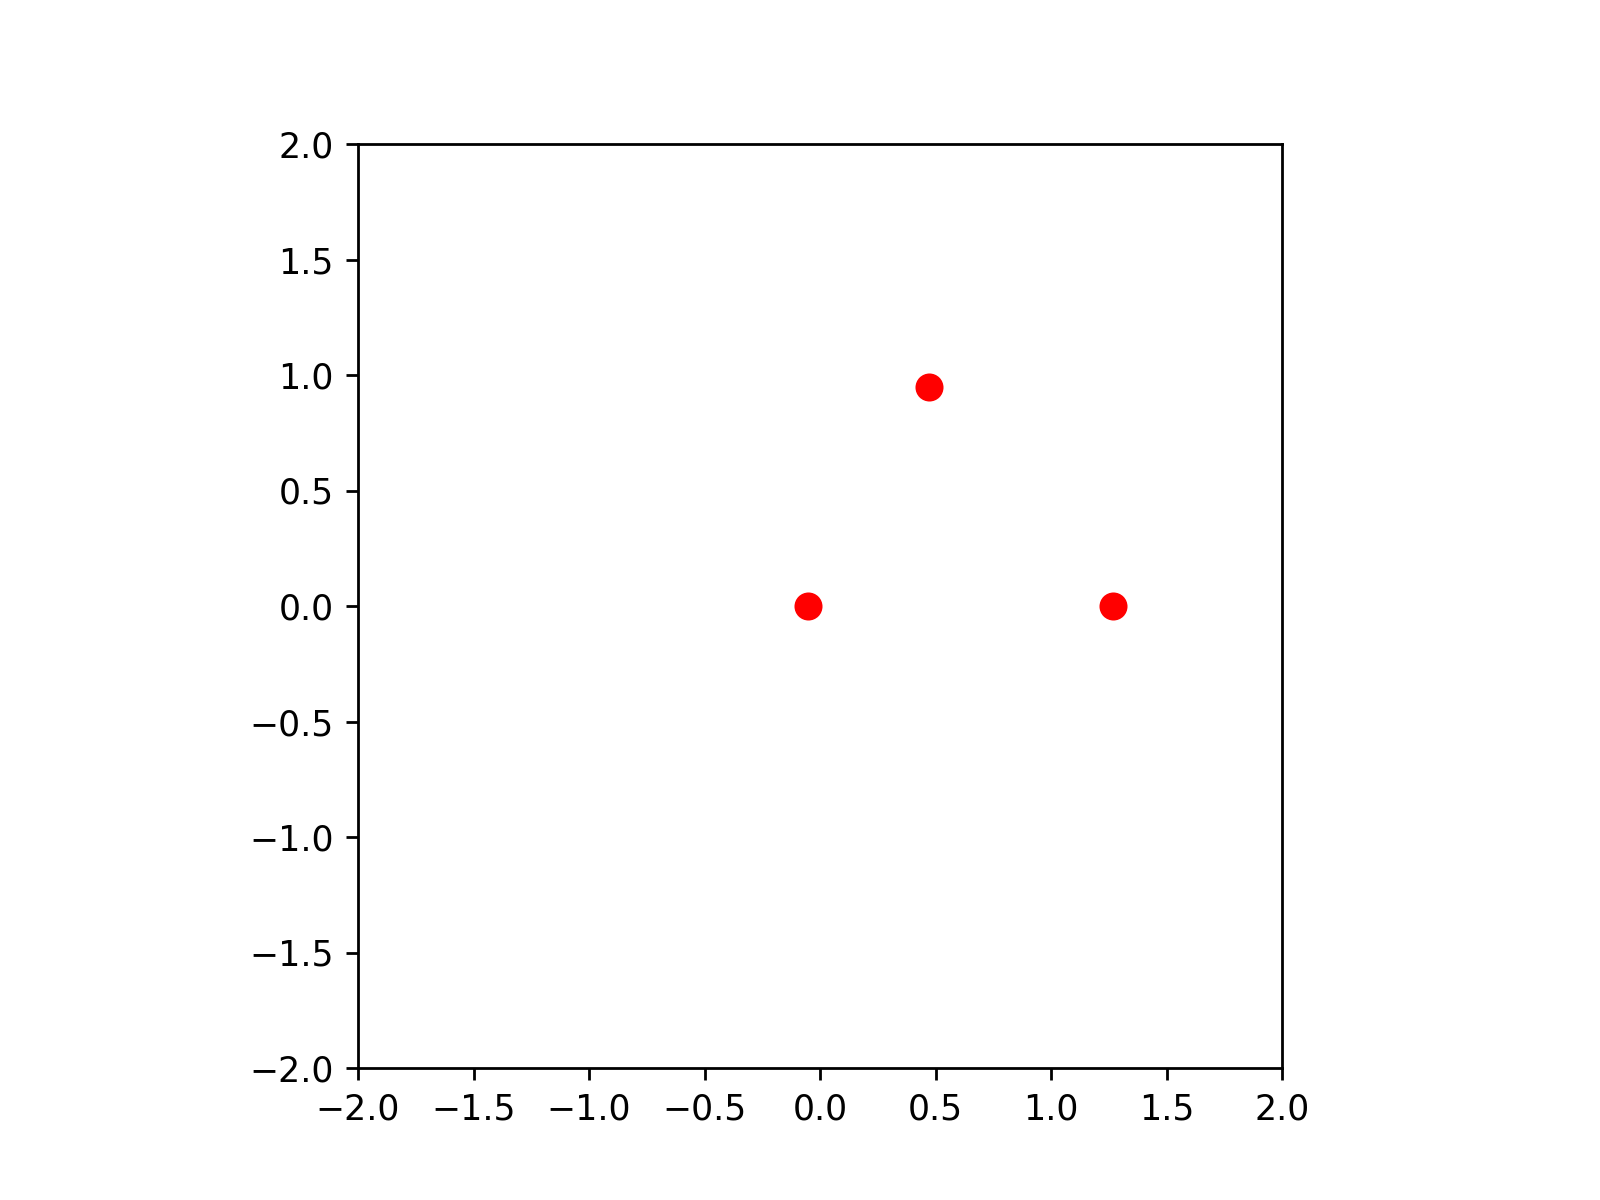

Initial node positions:
[[0.  0. ]
 [1.  0. ]
 [0.5 1. ]]
Mode shape:
[ 0.1   0.   -0.5   0.    0.05  0.1 ]
0.5


In [65]:
nodes = [(0, 0), (1, 0), (0.5, 1)]  # Node positions
springs = [(0, 1), (1, 2), (2, 0)]  # Springs
mode = np.array([0.1, 0, -0.5, 0, 0.05, 0.1])  # Mode shape: [x1, y1, x2, y2, x3, y3]
frequency = 2.0  # Natural frequency (rad/s)

fig, ani = visualize_modes_2d(nodes, springs, mode, 10*frequency)



Starting visualization setup...


<IPython.core.display.Javascript object>


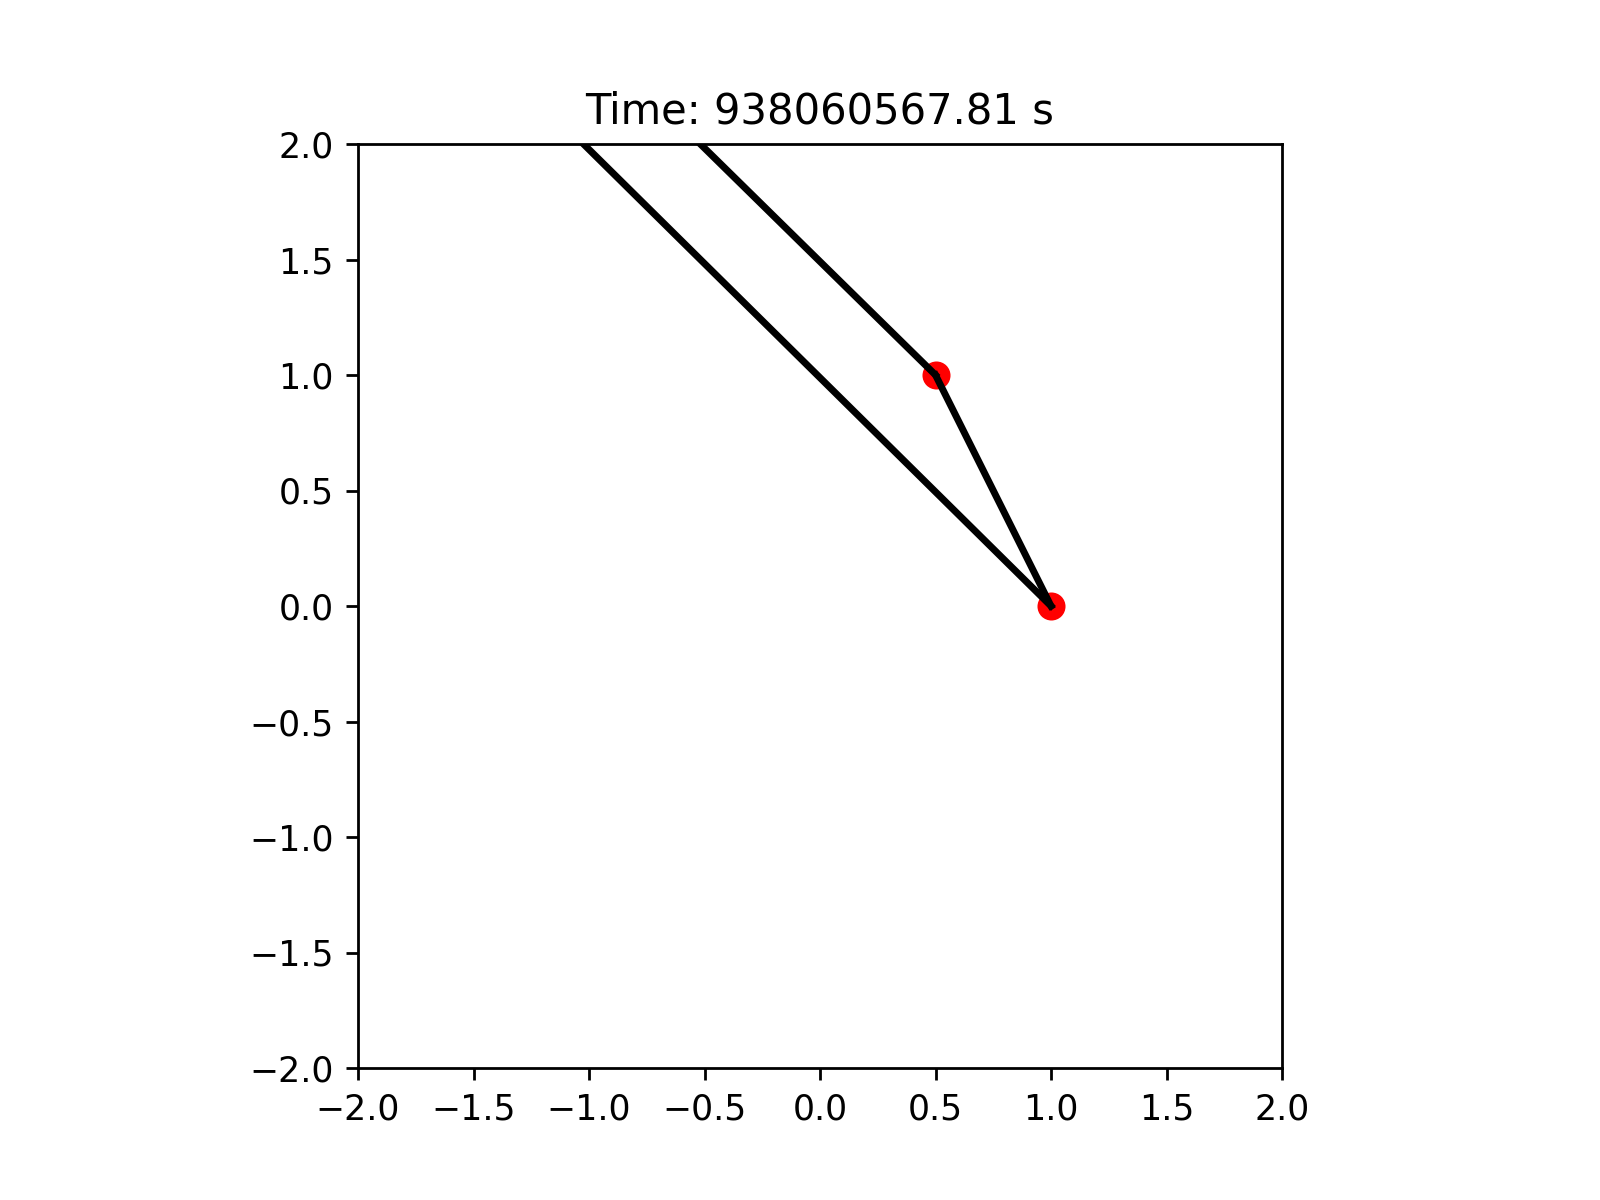

Figure created
Initial node positions:
[[0.  0. ]
 [1.  0. ]
 [0.5 1. ]]
Complex mode shape:
[-0.05190991-0.01523145j -0.05190991+0.01523145j  0.65465367+0.j
 -0.26726124+0.j          0.53452248+0.j         -0.46291005+0.j        ]
Complex frequency: (9.182284633687488e-09-1.6745148242020434e-09j)
Creating animation...
Animation object created
Animation details: <matplotlib.animation.FuncAnimation object at 0x7fa9f59ff8b0>


<IPython.core.display.Javascript object>


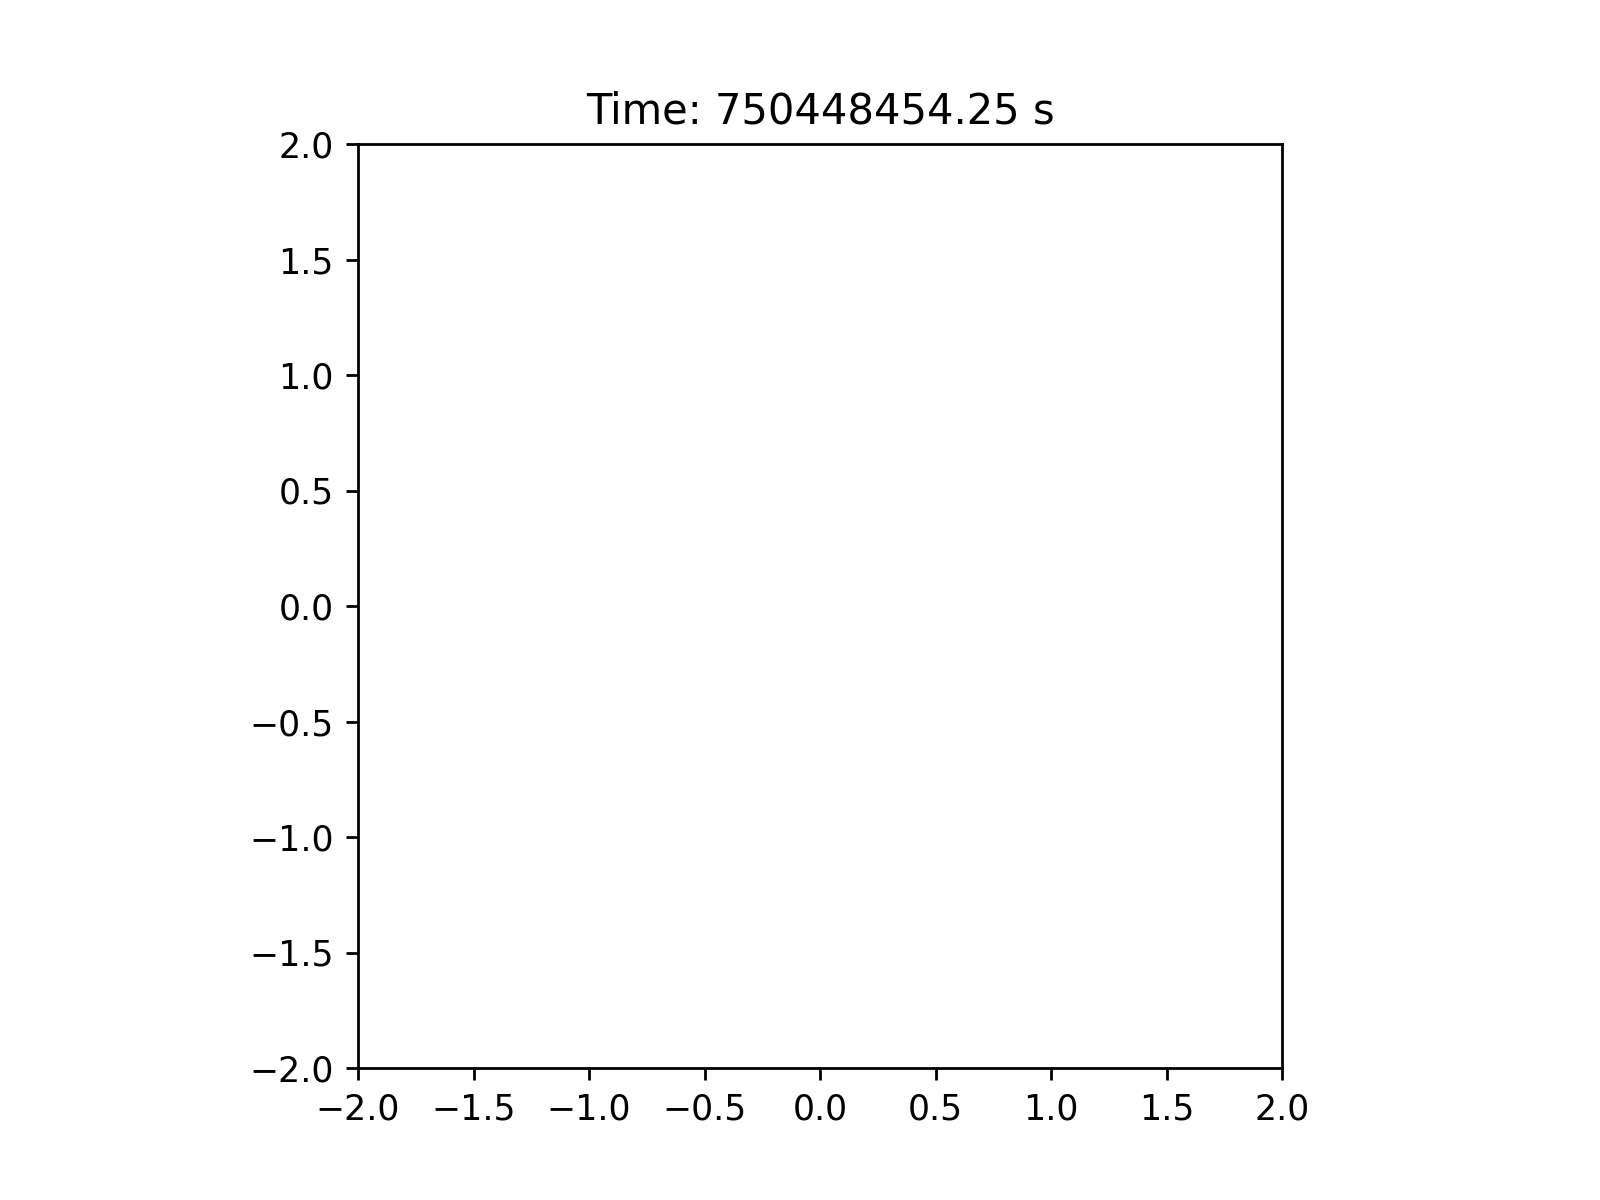

In [67]:
n = 2*3
nodes = [(0, 0), (1, 0), (0.5, 1)]  # Node positions
springs = [(0, 1), (1, 2), (2, 0)]  # Springs
M = np.diag(m*np.ones(n))
k_values = k*np.ones(n)
K = assemble_stiffness_2d(nodes, springs, k_values)
freqs, modes = calculate_normal_modes(M, K)

fig, ani = visualize_complex_modes_2d(nodes, springs, modes[0], freqs[0])

In [61]:
modes[0]

array([-0.05190991-0.01523145j, -0.05190991+0.01523145j,
        0.65465367+0.j        , -0.26726124+0.j        ,
        0.53452248+0.j        , -0.46291005+0.j        ])